In [1]:
import torch
import torch.nn as nn

In [2]:
import pandas as pd
import numpy as np

train_df = pd.read_csv("part-00000-36d")
val_df = pd.read_csv("./validation/part-00000")

In [3]:
train = train_df.to_numpy()
val = val_df.to_numpy()

In [4]:
train_labels = train[:,0]
train_timestamps = train[:,1]
train_data = train[:,2:]

val_labels = val[:,0]
val_timestamps = val[:,1]
val_data = val[:,2:]

train_labels = train_labels.reshape(-1,1)

In [5]:
train_data = np.concatenate((train_labels, train_data), axis=1)

In [6]:
from torch.nn.utils.rnn import pad_sequence

#timestamps without data? 
#Should Add timestamp as a feature. 
def create_input_sequence(input_data, input_labels, timestamps):

    input_data = torch.tensor(input_data, dtype=torch.float32)
    input_labels = torch.tensor(input_labels, dtype=torch.float32)
    
    max_timestamp = int(max(timestamps))

    train_sequence = [[] for i in range(max_timestamp+1)]
    train_labels = [0 for i in range(max_timestamp+1)]

    for i in range(len(input_data)):
        timestamp = int(timestamps[i])
        train_sequence[timestamp].append(input_data[i])
        train_labels[timestamp] = input_labels[i]

    for i in range(len(train_sequence)):
        if train_sequence[i]:
            train_sequence[i] = torch.stack(train_sequence[i], dim=0)
    
    # print(train_sequence)
    #Calculate mean of each timestep, could try to use encoder-decoder 
    for i in range(len(train_sequence)):
        if len(train_sequence[i]) == 0:
            train_sequence[i] = train_sequence[i-1]
            train_labels[i] = train_labels[i-1]
        else:
            train_sequence[i] = torch.mean(train_sequence[i], dim=0)
    
    # #First pad, since the data entries in each week is different.
    # #pad_train_sequence = pad_sequence(train_sequence)

    train_sequence = torch.stack(train_sequence)
    train_labels = torch.stack(train_labels, dim=0)
    # train_labels = train_labels.view(-1,1)

    return train_sequence, train_labels

In [7]:
data_x, data_y = create_input_sequence(train_data, train_labels, train_timestamps)

In [8]:
train_size = len(data_x) // 4 * 3

train_x, train_y = data_x[:train_size], data_y[:train_size]
val_x, val_y = data_x[train_size:], data_y[train_size:]

In [9]:
train_x = (train_x - train_x.mean(axis=0)) / train_x.std(axis=0)
train_y = (train_y - train_y.mean(axis=0)) / train_y.std(axis=0)

In [10]:
#Should NOT normalize validation data!
data_x = (data_x - data_x.mean(axis=0)) / data_x.std(axis=0)
data_y = (data_y - data_y.mean(axis=0)) / data_y.std(axis=0)

In [11]:
batch_size = 64
data_size = train_x.size()[0]

batch_x = []
batch_y = []
for i in range(batch_size, len(train_x)):
    batch_x.append(train_x[i-batch_size:i])
    batch_y.append(train_y[i-batch_size:i])
    # batch_x.append(train_x[i:])
    # batch_y.append(train_y[i:])

batch_var_x = pad_sequence(batch_x)
batch_var_y = pad_sequence(batch_y)

In [25]:
from torch.utils.data import Dataset, DataLoader
import os
import glob
import pandas as pd


class PlusgradeDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data, self.labels = self.get_data_labels(data_path)
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return self.data.iloc[index], self.label[index]

    def get_data_labels(self, data_path):
        all_files = glob.glob(os.path.join(data_path, "part*"))
        sharded_dataset = (pd.read_csv(f, header=None, engine='python') for f in all_files)
        dataset = pd.concat(sharded_dataset, ignore_index=True)

        labels = dataset.iloc[:,0]
        data = dataset.drop(dataset.columns[0], axis=1)

        

        return data, labels



In [351]:
%%writefile ./pytorch-train.py

import glob
import numpy as np
import pandas as pd
import argparse
import json
import logging
import os
import sys
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torch.utils.data.distributed

from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

class PlusgradeDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data, self.labels = self.get_data_labels(data_path)
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

    def get_data_labels(self, data_path):
        all_files = glob.glob(os.path.join(data_path, "part*"))
        sharded_dataset = (pd.read_csv(f, header=None, engine='python') for f in all_files)
        dataset = pd.concat(sharded_dataset, ignore_index=True)

        dataset = dataset.to_numpy().astype(np.float32)

        labels = dataset[:,0]
        data = dataset[:,2:]

        #scaler
        m = data.mean(axis=0)
        s = data.std(axis=0)
        data -= m
        data /= s

        data = np.nan_to_num(data)
        
        return self.create_input_sequence(data, labels)

    def transform_data(self, input_data, input_labels, time_steps=2):

        input_size = input_data.shape[1]

        x, y = [], []
        for i in range(len(input_data) - time_steps):
            x_i = input_data[i:i + time_steps]
            y_i = input_data[i+1:i+time_steps+1]
            x.append(x_i)
            y.append(y_i)
        x_arr = np.array(x).reshape(-1, time_steps)
        y_arr = np.array(y).reshape(-1, time_steps)

        x_var = Variable(torch.from_numpy(x_arr).float())
        y_var = Variable(torch.from_numpy(y_arr).float())
        return x_var, y_var
    
    def create_input_sequence(input_data, input_labels, timestamps):

        input_data = torch.tensor(input_data, dtype=torch.float32)
        input_labels = torch.tensor(input_labels, dtype=torch.float32)
        
        max_timestamp = int(max(timestamps))

        train_sequence = [[] for i in range(max_timestamp+1)]
        train_labels = [0 for i in range(max_timestamp+1)]

        for i in range(len(input_data)):
            timestamp = int(timestamps[i])
            train_sequence[timestamp].append(input_data[i])
            train_labels[timestamp] = input_labels[i]


        for i in range(len(train_sequence)):
            train_sequence[i] = torch.stack(train_sequence[i], dim=0)
        
        pad_train_sequence = pad_sequence(train_sequence)

        return pad_train_sequence, train_labels

    def create_input_sequence(self, input_data, input_labels, time_steps=2):
        train_sequence = []
        train_labels = []
        L = len(input_data)

        for i in range(L - time_steps):
            train_seq = input_data[i:i+time_steps]
            train_label = input_labels[i+time_steps:i+time_steps+1]
            train_sequence.append(train_seq)
            train_labels.append(train_label)

        #train_sequence = torch.from_numpy(np.array(train_sequence))
        #train_sequence = train_sequence.transpose(1,0)
        
        return train_sequence, train_labels
    

def _get_train_data_loader(batch_size, training_dir, is_distributed, **kwargs):
    logger.info("Get train data sampler and data loader")
    dataset = PlusgradeDataset(training_dir)
    train_sampler = torch.utils.data.distributed.DistributedSampler(dataset) if is_distributed else None
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train_sampler is None, sampler=train_sampler, **kwargs)
    return train_loader

def _get_validation_data_loader(batch_size, validation_dir, **kwargs):
    logger.info("Get validation data sampler and data loader")
    dataset = PlusgradeDataset(validation_dir)
    #validation_sampler = torch.utils.data.distributed.DistributedSampler(dataset, num_replicas=hvd.size(), rank=hvd.rank())
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=None, **kwargs)
    return validation_loader

def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.transpose(1,0)
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, target, size_average=False).item()  # sum up batch loss
    test_loss /= len(test_loader.dataset)
    logger.info('Test set: Average loss: {:.4f}'.format(
        test_loss))


class TransformerNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TransformerNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.output_size)
        )

    def forward(self, input):

        #print('input', input.size())
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(1), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(1), self.hidden_size, dtype=torch.float32)
        #print('h_t', h_t.size())
        #print(c_t.size())

        for i in range(input.size()[0]):
            h_t, c_t = self.lstm(input[i], (h_t, c_t))
            output = self.fc(h_t)
            outputs.append(output)

        # for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
        #     print('input_t', input_t.size())
        #     h_t, c_t = self.lstm(input_t, (h_t, c_t))
        #     output = self.fc(h_t)
        #     outputs += [output]
        #outputs = torch.stack(outputs, 1).squeeze(2)
        outputs = torch.stack(outputs, dim=0)
        outputs = torch.mean(outputs, dim=0)
        print('outputs', outputs.size())

        return outputs


def train(args):
    is_distributed = False
    logger.debug("Distributed training - {}".format(is_distributed))
    use_cuda = args.num_gpus > 0
    logger.debug("Number of gpus available - {}".format(args.num_gpus))
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    device = torch.device("cuda" if use_cuda else "cpu")

    if is_distributed:
        # Initialize the distributed environment.
        world_size = len(args.hosts)
        os.environ['WORLD_SIZE'] = str(world_size)
        host_rank = args.hosts.index(args.current_host)
        os.environ['RANK'] = str(host_rank)
        dist.init_process_group(backend=args.backend, rank=host_rank, world_size=world_size)
        logger.info('Initialized the distributed environment: \'{}\' backend on {} nodes. '.format(
            args.backend, dist.get_world_size()) + 'Current host rank is {}. Number of gpus: {}'.format(
            dist.get_rank(), args.num_gpus))

    # set the seed for generating random numbers
    torch.manual_seed(args.seed)
    if use_cuda:
        torch.cuda.manual_seed(args.seed)

    train_loader = _get_train_data_loader(args.batch_size, args.data_dir, is_distributed, **kwargs)
    validation_loader = _get_validation_data_loader(args.test_batch_size, './validation', **kwargs)

    logger.debug("Processes {}/{} ({:.0f}%) of train data".format(
        len(train_loader.sampler), len(train_loader.dataset),
        100. * len(train_loader.sampler) / len(train_loader.dataset)
    ))

    logger.debug("Processes {}/{} ({:.0f}%) of test data".format(
        len(validation_loader.sampler), len(validation_loader.dataset),
        100. * len(validation_loader.sampler) / len(validation_loader.dataset)
    ))

    model = TransformerNet(input_size=36, hidden_size=21, output_size=1).to(device)
    if is_distributed and use_cuda:
        # multi-machine multi-gpu case
        model = torch.nn.parallel.DistributedDataParallel(model)
    else:
        # single-machine multi-gpu case or single-machine or multi-machine cpu case
        model = torch.nn.DataParallel(model)

    loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = StepLR(optimizer, step_size=args.step_size, gamma=0.1)

    for epoch in range(1, args.epochs + 1):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader, 1):
            data = data.transpose(1,0)
            #print('data', data.size())
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            #print('output', output.size())
            batch_loss = loss(output, target)
            batch_loss.backward()
            if is_distributed and not use_cuda:
                # average gradients manually for multi-machine cpu case only
                _average_gradients(model)
            optimizer.step()
            if batch_idx % args.log_interval == 0:
                logger.info('Train Epoch: {} [{}/{} ({:.0f}%)] Batch Loss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.sampler),
                    100. * batch_idx / len(train_loader), batch_loss.item()))
        test(model, validation_loader, device)
        scheduler.step()
    save_model(model, args.model_dir)
    

def model_fn(model_dir):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.nn.DataParallel(Net())
    with open(os.path.join(model_dir, 'model.pth'), 'rb') as f:
        model.load_state_dict(torch.load(f))
    return model.to(device)

def save_model(model, model_dir):
    logger.info("Saving the model.")
    path = os.path.join(model_dir, 'model.pth')
    # recommended way from http://pytorch.org/docs/master/notes/serialization.html
    torch.save(model.cpu().state_dict(), path)

if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Data and model checkpoints directories
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=64, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=30, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 0.001)')
    parser.add_argument('--step-size', type=int, default=10, metavar='N',
                        help='learning rate decay (default: 10)')
    parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--backend', type=str, default=None,
                        help='backend for distributed training (tcp, gloo on cpu and gloo, nccl on gpu)')

    # Container environment
    parser.add_argument('--hosts', type=list, default=[])
    parser.add_argument('--current-host', type=str, default='')
    parser.add_argument('--model-dir', type=str, default='./')
    parser.add_argument('--data-dir', type=str, default='./')
    parser.add_argument('--num-gpus', type=int, default=0)

    train(parser.parse_args())

Overwriting ./pytorch-train.py


In [12]:
class RegLSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, mid_dim, mid_layers):
        super(RegLSTM, self).__init__()

        self.rnn = nn.LSTM(inp_dim, mid_dim, mid_layers)  # rnn
        self.reg = nn.Sequential(
            nn.Linear(mid_dim, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, out_dim),
        )  # regression

    def forward(self, x):
        y = self.rnn(x)[0]  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.shape
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y
    
    def output_y_hc(self, x, hc):
        y, hc = self.rnn(x, hc)  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.size()
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y, hc

In [27]:
inp_dim = 37
out_dim = 1
mid_dim = 100
mid_layers = 1
mod_dir = '.'

net = RegLSTM(inp_dim, out_dim, mid_dim, mid_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [28]:
print("Training Start")
for e in range(200):
    out = net(batch_var_x)

    loss = criterion(out, batch_var_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 64 == 0:
        print('Epoch: {:4}, Loss: {:.5f}'.format(e, loss.item()))
torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))
print("Save in:", '{}/net.pth'.format(mod_dir))

Training Start
Epoch:    0, Loss: 1.39625
Epoch:   64, Loss: 0.00271
Epoch:  128, Loss: 0.00037
Epoch:  192, Loss: 0.00011
Save in: ./net.pth


In [32]:
#train_size = len(data_x) // 4 * 3
train_size = 1

In [33]:
net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir), map_location=lambda storage, loc: storage))
net = net.eval()

test_x = data_x.clone()
test_x[train_size:, 0] = 0
test_x = test_x[:, np.newaxis, :]

'''elegant way but slightly complicated'''
eval_size = 1
zero_ten = torch.zeros((mid_layers, eval_size, mid_dim), dtype=torch.float32)
test_y, hc = net.output_y_hc(test_x[:train_size], (zero_ten, zero_ten))
test_x[train_size + 1, 0, 0] = test_y[-1]
for i in range(train_size + 1, len(data_x) - 2):
    test_y, hc = net.output_y_hc(test_x[i:i + 1], hc)
    test_x[i + 1, 0, 0] = test_y[-1]
pred_y = test_x[1:, 0, 0]
pred_y = pred_y.cpu().data.numpy()

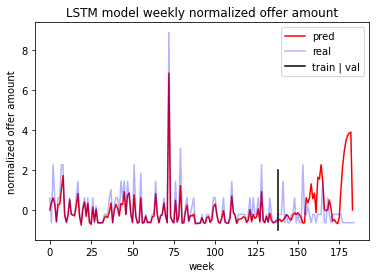

In [34]:
import matplotlib.pyplot as plt

train_size = len(data_x) // 4 * 3
plt.plot()
plt.xlabel('week')
plt.ylabel('normalized offer amount')
plt.title('LSTM model weekly normalized offer amount')
plt.plot(pred_y, 'r', label='pred')
plt.plot(data_y, 'b', label='real', alpha=0.3)
plt.plot([train_size, train_size], [-1, 2], color='k', label='train | val')
plt.legend(loc='best')
plt.savefig('LSTM.png')
plt.pause(4)

In [35]:
#data_y = data_y.cpu().detach().numpy()
diff_y = pred_y[train_size:] - data_y[train_size:-1]
l1_loss = np.mean(np.abs(diff_y))
l2_loss = np.mean(diff_y ** 2)
print("L1: {:.3f}    L2: {:.3f}".format(l1_loss, l2_loss))

L1: 1.070    L2: 2.596


In [71]:
from sklearn.metrics import r2_score

r2_score(data_y[train_size:-1], pred_y[train_size:])

-0.6904141770528769